# Prediction after feature engineering

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()
seed = 0
lr = 0.001
batch_size = 16
epochs = 35
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pol_parties = ['ADPL', 'BPA', 'CIV', 'CivP', 'CivPass', 'DAB', 'DP', 'Demosisto', 'FTU', 'IND', 'LAB', 'LIB', 'LSD', 'NPP', 'NWSC', 'NeoDem', 'PathDem', 'PeoP', 'Young']
blocs = ['CEN', 'DEM', 'EST', 'IND', 'LOC']

In [3]:
dcca_11c = pd.read_csv('dcca_11c_processed.csv')
dcca_16bc = pd.read_csv('dcca_16bc_processed.csv')
le_legco_winner_party = LabelEncoder().fit(pol_parties)
le_legco_winner_bloc = LabelEncoder().fit(blocs)

In [4]:
X = dcca_11c.drop(['ca_chi', 'legco2012_winner', 'legco2016_winner'], axis=1)
try:
    y = le_legco_winner_party.transform(dcca_11c['legco2012_winner'])
except ValueError:
    y = le_legco_winner_bloc.transform(dcca_11c['legco2012_winner'])

In [5]:
n_features = len(X.columns)
n_classes = len(pol_parties)

In [6]:
class DCCADataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.transform = transform
        if self.transform is not None:
            self.features = self.transform(features)
        else:
            self.features = features.to_numpy()
        self.targets = targets
        self.samples = []
        for feature, target in zip(self.features, self.targets):
            self.samples.append((feature, target))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
need_scaler = True
if need_scaler:
    scaler = StandardScaler().fit(X)
    X[X.columns] = scaler.transform(X)

## Preparing for Classification

In [8]:
train_valid_X, test_X, train_valid_y, test_y = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)
train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, test_size=1/9, random_state=seed, stratify=train_valid_y)

In [9]:
train_dataset = DCCADataset(train_X, train_y)
valid_dataset = DCCADataset(valid_X, valid_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Predicting 2012 Results
### Decision Tree Model

In [10]:
dtc = DecisionTreeClassifier(random_state=seed).fit(train_valid_X, train_valid_y)
print(f'Training accuracy: {100 * dtc.score(train_X, train_y):.2f}%')
print(f'Validation accuracy: {100 * dtc.score(valid_X, valid_y):.2f}%')
print(f'Test accuracy: {100 * dtc.score(test_X, test_y):.2f}%')

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 51.28%


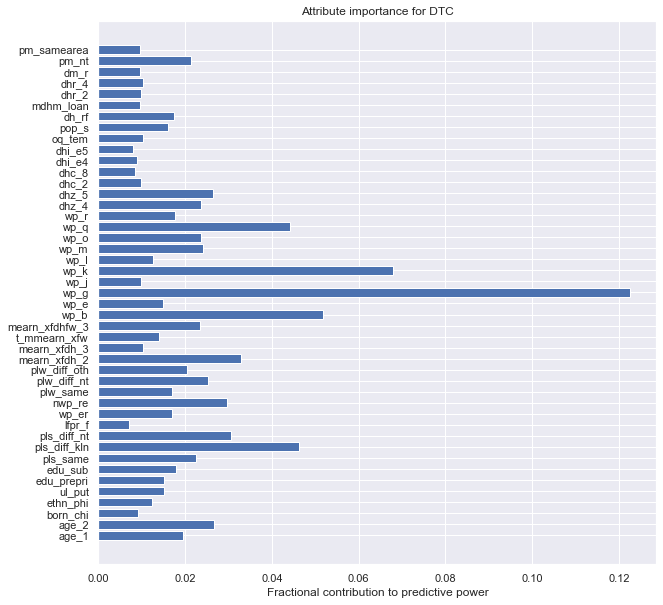

In [11]:
plt.figure(figsize=(10, 10))
plt.barh(X.columns[dtc.feature_importances_ > 0], dtc.feature_importances_[dtc.feature_importances_ > 0])
plt.title("Attribute importance for DTC")
plt.xlabel("Fractional contribution to predictive power")
plt.show()

<AxesSubplot:>

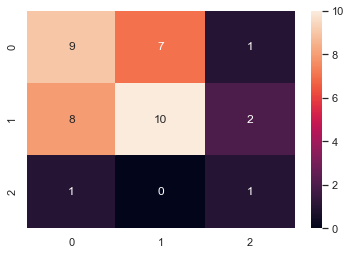

In [12]:
dtc_cfmt = confusion_matrix(test_y, dtc.predict(test_X))
sns.heatmap(dtc_cfmt, annot=True)

### Random Forest Model

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 61.54%


<AxesSubplot:>

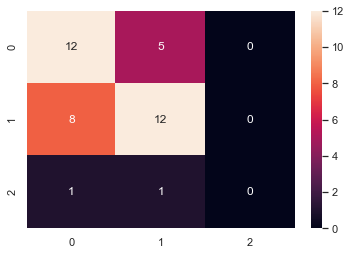

In [13]:
rfc = RandomForestClassifier(random_state=seed, n_estimators=100).fit(train_valid_X, train_valid_y)
print(f'Training accuracy: {100 * rfc.score(train_X, train_y):.2f}%')
print(f'Validation accuracy: {100 * rfc.score(valid_X, valid_y):.2f}%')
print(f'Test accuracy: {100 * rfc.score(test_X, test_y):.2f}%')
rfc_cfmt = confusion_matrix(test_y, rfc.predict(test_X))
sns.heatmap(rfc_cfmt, annot=True)

### Principal Component Analysis + Random Forest

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 53.85%


<AxesSubplot:>

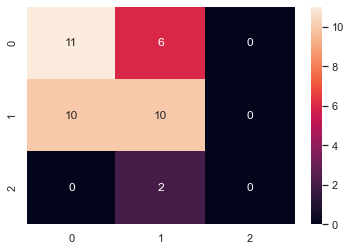

In [14]:
pca = PCA()
pca_X = pca.fit_transform(X)
pca_tv_X, pca_test_X, pca_tv_y, pca_test_y = train_test_split(pca_X, y, test_size=0.1, random_state=seed, stratify=y)
pca_train_X, pca_valid_X, pca_train_y, pca_valid_y = train_test_split(pca_tv_X, pca_tv_y, test_size=1/9, random_state=seed, stratify=pca_tv_y)
pcarfc = RandomForestClassifier(random_state=seed, n_estimators=100).fit(pca_tv_X, pca_tv_y)
print(f'Training accuracy: {100 * pcarfc.score(pca_train_X, pca_train_y):.2f}%')
print(f'Validation accuracy: {100 * pcarfc.score(pca_valid_X, pca_valid_y):.2f}%')
print(f'Test accuracy: {100 * pcarfc.score(pca_test_X, pca_test_y):.2f}%')
pcarfc_cfmt = confusion_matrix(pca_test_y, pcarfc.predict(pca_test_X))
sns.heatmap(pcarfc_cfmt, annot=True)

### Linear Discriminant Analysis

In [15]:
lda = LinearDiscriminantAnalysis().fit(train_X, train_y)
print(f'Training accuracy: {100 * lda.score(train_X, train_y):.2f}%')
print(f'Validation accuracy: {100 * lda.score(valid_X, valid_y):.2f}%')
print(f'Test accuracy: {100 * lda.score(test_X, test_y):.2f}%')

Training accuracy: 91.12%
Validation accuracy: 36.84%
Test accuracy: 46.15%


### Quadratic Discriminant Analysis

In [16]:
qda = QuadraticDiscriminantAnalysis().fit(train_valid_X, train_valid_y)
print(f'Training accuracy: {100 * qda.score(train_X, train_y):.2f}%')
print(f'Validation accuracy: {100 * qda.score(valid_X, valid_y):.2f}%')
print(f'Test accuracy: {100 * qda.score(test_X, test_y):.2f}%')

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 51.28%


C:\Users\HP\Anaconda3\envs\AI-env\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Logistic Regression Model

In [17]:
lrg = SGDClassifier(random_state=seed, loss='log',
                       early_stopping=True, 
                       validation_fraction=1/9).fit(train_valid_X, train_valid_y)
print(f'Training accuracy: {100 * lrg.score(train_X, train_y):.2f}%')
print(f'Validation accuracy: {100 * lrg.score(valid_X, valid_y):.2f}%')
print(f'Test accuracy: {100 * lrg.score(test_X, test_y):.2f}%')

Training accuracy: 76.97%
Validation accuracy: 63.16%
Test accuracy: 51.28%


### Multilayer Classifier Model

In [18]:
mlp = MLPClassifier((n_features,), random_state=seed,
                       early_stopping=True).fit(train_valid_X, train_valid_y)
print(f'Training accuracy: {100 * mlp.score(train_X, train_y):.2f}%')
print(f'Validation accuracy: {100 * mlp.score(valid_X, valid_y):.2f}%')
print(f'Test accuracy: {100 * mlp.score(test_X, test_y):.2f}%')

Training accuracy: 69.74%
Validation accuracy: 73.68%

C:\Users\HP\Anaconda3\envs\AI-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\HP\Anaconda3\envs\AI-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\HP\Anaconda3\envs\AI-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\HP\Anaconda3\envs\AI-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\HP\Anaconda3\envs\AI-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MLPClassi


Test accuracy: 64.10%


In [19]:
class MLP(nn.Module):
    def __init__(self, n_features, n_classes):
        super(MLP, self).__init__()
        self.classifier = nn.Sequential(nn.Linear(n_features, n_features // 4),
                                        nn.ReLU(),
                                        nn.Linear(n_features // 4, n_classes)
                                       )
    
    def forward(self, x):
        logits = self.classifier(x)
        probs = nn.functional.softmax(logits, dim=1)
        return logits, probs

In [20]:
model = MLP(n_features, n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-2)
criterion = nn.CrossEntropyLoss().to(device)

In [21]:
def get_accuracy(model, data_loader, device='cpu'):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y in data_loader:
            X = X.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            n += y.size(0)
            correct_pred += (predicted_labels == y).sum()

    return float(correct_pred) / n

In [22]:
def train(model, optimizer, criterion, device='cpu'):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.long)
        y_pred, _ = model(X)
        loss = criterion(y_pred, y.long())
        train_loss += loss.item() * X.size(0)
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_loss / len(train_X)
    return epoch_loss

In [23]:
def validate(model, optimizer, criterion, device='cpu'):
    model.eval()
    valid_loss = 0
    for X, y in valid_loader:
        optimizer.zero_grad()
        X = X.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.long)
        y_pred, _ = model(X)
        loss = criterion(y_pred, y)
        valid_loss += loss.item() * X.size(0)
    
    epoch_loss = valid_loss / len(valid_X)
    return epoch_loss

In [24]:
def train_and_validate(model, optimizer, criterion, epochs=50, device='cpu', print_every=5):
    train_losses = []
    valid_losses = []
 
    for epoch in range(epochs):
        # training
        train_loss = train(model, optimizer, criterion, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            valid_loss = validate(model, optimizer, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device)
            valid_acc = get_accuracy(model, valid_loader, device)
            print(f'Epoch: {epoch:>2}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}%\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}%')
    
    return train_losses, valid_losses

In [25]:
train_losses, valid_losses = train_and_validate(model, optimizer, criterion, epochs, device)

Epoch:  4	Train loss: 0.8656	Valid loss: 0.8348	Train accuracy: 68.42%	Valid accuracy: 60.53%
Epoch:  9	Train loss: 0.7535	Valid loss: 0.7903	Train accuracy: 70.39%	Valid accuracy: 60.53%
Epoch: 14	Train loss: 0.6900	Valid loss: 0.7809	Train accuracy: 73.36%	Valid accuracy: 60.53%
Epoch: 19	Train loss: 0.6475	Valid loss: 0.7723	Train accuracy: 75.33%	Valid accuracy: 60.53%
Epoch: 24	Train loss: 0.6128	Valid loss: 0.7815	Train accuracy: 77.96%	Valid accuracy: 55.26%
Epoch: 29	Train loss: 0.5759	Valid loss: 0.7940	Train accuracy: 79.93%	Valid accuracy: 57.89%
Epoch: 34	Train loss: 0.5441	Valid loss: 0.7977	Train accuracy: 84.54%	Valid accuracy: 55.26%


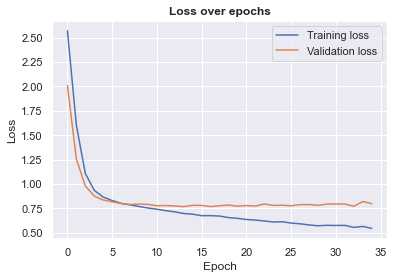

In [26]:
sns.lineplot(x=list(range(epochs)), y=train_losses, label='Training loss')
sns.lineplot(x=list(range(epochs)), y=valid_losses, label='Validation loss')
plt.title('Loss over epochs', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [27]:
test_dataset = DCCADataset(test_X, test_y)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

test_accuracy = get_accuracy(model, test_loader, device)
print(f'Testing Accuracy: {100 * test_accuracy:.2f}%')

Testing Accuracy: 64.10%


## Predicting 2016 Results Using 2012 Model

In [28]:
year = 2012
if year == 2012:
    X = dcca_11c.drop(['ca_chi', 'legco2012_winner', 'legco2016_winner'], axis=1)
    try:
        y = le_legco_winner_party.transform(dcca_11c['legco2016_winner'])
    except ValueError:
        y = le_legco_winner_bloc.transform(dcca_11c['legco2016_winner'])
else:
    X = dcca_16bc.drop(['ca_chi', 'legco2016_winner'], axis=1)
    try:
        y = le_legco_winner_party.transform(dcca_16bc['legco2016_winner'])
    except ValueError:
        y = le_legco_winner_bloc.transform(dcca_16bc['legco2016_winner'])
if need_scaler:
    X[X.columns] = scaler.transform(X)

In [29]:
print(f'Decision Tree Accuracy: {dtc.score(X, y) * 100:.2f}%')
print(f'Random Forest Accuracy: {rfc.score(X, y) * 100:.2f}%')
print(f'PCA Accuracy: {pcarfc.score(pca.transform(X), y) * 100:.2f}%')
print(f'LDA Accuracy: {lda.score(X, y) * 100:.2f}%')
print(f'QDA Accuracy: {qda.score(X, y) * 100:.2f}%')
print(f'Logistic Regression Accuracy: {lrg.score(X, y) * 100:.2f}%')
print(f'Multilayer Perceptron Accuracy: {mlp.score(X, y) * 100:.2f}%')

Decision Tree Accuracy: 49.87%
Random Forest Accuracy: 50.13%
PCA Accuracy: 48.82%
LDA Accuracy: 47.24%
QDA Accuracy: 51.97%
Logistic Regression Accuracy: 50.39%
Multilayer Perceptron Accuracy: 51.97%


In [30]:
dataset = DCCADataset(X, y)
loader = DataLoader(dataset, batch_size, shuffle=False)

accuracy = get_accuracy(model, loader, device)
print(f'PyTorch MLP Accuracy: {100 * accuracy:.2f}%')

PyTorch MLP Accuracy: 53.02%


We see that the models' performance are similar to random guessing, even after normalization of the dataset. Especially, from the 2012 test data, we can see that the model actually cannot discriminate the classes '0' (Democrats) and '1' (Pro-establishment bloc). This may actually be a surprising phenomenon.

In [31]:
try:
    dtc_pred = le_legco_winner_party.inverse_transform(dtc.predict(X))
    rfc_pred = le_legco_winner_party.inverse_transform(rfc.predict(X))
    pca_pred = le_legco_winner_party.inverse_transform(pcarfc.predict(pca.transform(X)))
    lda_pred = le_legco_winner_party.inverse_transform(lda.predict(X))
    qda_pred = le_legco_winner_party.inverse_transform(qda.predict(X))
    lrg_pred = le_legco_winner_party.inverse_transform(lrg.predict(X))
    mlp_pred = le_legco_winner_party.inverse_transform(mlp.predict(X))
except:
    dtc_pred = le_legco_winner_bloc.inverse_transform(dtc.predict(X))
    rfc_pred = le_legco_winner_bloc.inverse_transform(rfc.predict(X))
    pca_pred = le_legco_winner_bloc.inverse_transform(pcarfc.predict(pca.transform(X)))
    lda_pred = le_legco_winner_bloc.inverse_transform(lda.predict(X))
    qda_pred = le_legco_winner_bloc.inverse_transform(qda.predict(X))
    lrg_pred = le_legco_winner_bloc.inverse_transform(lrg.predict(X))
    mlp_pred = le_legco_winner_bloc.inverse_transform(mlp.predict(X))

In [32]:
model_pred = np.array([])
with torch.no_grad():
    model.eval()
    for X_, y_ in loader:
        X_ = X_.to(device=device, dtype=torch.float)
        y_ = y_.to(device=device, dtype=torch.long)
        _, y_prob = model(X_)
        _, predicted_labels = torch.max(y_prob, 1)
        model_pred = np.concatenate((model_pred, predicted_labels.detach().cpu().numpy()), axis=None)
try:
    model_pred = le_legco_winner_party.inverse_transform(model_pred.astype(int))
except:
    model_pred = le_legco_winner_bloc.inverse_transform(model_pred.astype(int))

In [33]:
prediction = pd.DataFrame({'ca_chi': dcca_11c['ca_chi'],
                           'dtc': dtc_pred,
                           'rfc': rfc_pred,
                           'pca': pca_pred,
                           'lda': lda_pred,
                           'qda': qda_pred,
                           'logreg': lrg_pred,
                           'mlp': mlp_pred,
                           'torch_mlp': model_pred,
                           'label': dcca_11c['legco2016_winner']
                          }).set_index('ca_chi')
prediction.to_csv('prediction.csv', encoding='utf-8-sig')